### **Real-Time Patient Outcome Simulation Platform**

Goal is to develop a prototype that uses simulation techniques to model and predict patient outcomes based on various treatment scenarios and interventions. This platform would enable providers to explore different treatment strategies and their potential impacts on patient health in a virtual environment enhancing clinical decision-making



The Real-Time Patient Outcome Simulation Platform can be crucial for Cotiviti as it enhances predictive analytics by allowing providers to model and forecast patient outcomes under various treatment scenarios. This innovative tool can support better decision-making and treatment optimization, improving patient care. Additionally, it can position Cotiviti as a leader in personalized healthcare solutions by offering advanced, risk-free simulations of medical interventions.

MIMIC -||| dataset is used to build the baseline model. <br>
What? Predicted based on historical data of similar profiles and standard treatments.<br>
How? Combination of historical data analysis, modeling, and clinical insights.<br>
Why?  It is useful for benchmarking and assessing improvements in patient outcomes. <br>

The dataset had multiple files containing different info that we first have to merge, then data is cleaned, preprocessed. <br>

Random forest regressor is used to build the model to predict Length of Stay of a patient based on standard procedures and interventions

In [ ]:
import pandas as pd

# Load the datasets
patients = pd.read_csv('PATIENTS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
icustays = pd.read_csv('ICUSTAYS.csv')
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv')
procedures = pd.read_csv('PROCEDURES_ICD.csv')



In [ ]:
# Inspect columns of each dataset
print("Patients columns:", patients.columns)
print("Admissions columns:", admissions.columns)
print("ICU Stays columns:", icustays.columns)
print("Diagnoses columns:", diagnoses.columns)
print("Procedures columns:", procedures.columns)


Patients columns: Index(['row_id', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag'],
      dtype='object')
Admissions columns: Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data'],
      dtype='object')
ICU Stays columns: Index(['row_id', 'subject_id', 'hadm_id', 'icustay_id', 'dbsource',
       'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid',
       'intime', 'outtime', 'los'],
      dtype='object')
Diagnoses columns: Index(['row_id', 'subject_id', 'hadm_id', 'seq_num', 'icd9_code'], dtype='object')
Procedures columns: Index(['row_id', 'subject_id', 'hadm_id', 'seq_num', 'icd9_code'], dtype='object')


In [ ]:
# Rename columns to avoid conflicts
patients = patients.rename(columns={'subject_id': 'patient_subject_id', 'row_id': 'patients_row_id'})
admissions = admissions.rename(columns={'subject_id': 'patient_subject_id', 'hadm_id': 'admission_id', 'row_id': 'admissions_row_id'})
icustays = icustays.rename(columns={'subject_id': 'patient_subject_id', 'hadm_id': 'admission_id', 'row_id': 'icustays_row_id'})
diagnoses = diagnoses.rename(columns={'subject_id': 'patient_subject_id', 'hadm_id': 'admission_id', 'row_id': 'diagnoses_row_id'})
procedures = procedures.rename(columns={'subject_id': 'patient_subject_id', 'hadm_id': 'admission_id', 'row_id': 'procedures_row_id'})


Merging the data

In [ ]:
# Merge ADMISSIONS with PATIENTS
admissions_patients = pd.merge(admissions, patients, left_on='patient_subject_id', right_on='patient_subject_id', how='inner')

# Merge the result with ICUSTAYS
admissions_patients_icustays = pd.merge(admissions_patients, icustays, left_on=['patient_subject_id', 'admission_id'], right_on=['patient_subject_id', 'admission_id'], how='left')

# Merge the result with DIAGNOSES
admissions_patients_icustays_diagnoses = pd.merge(admissions_patients_icustays, diagnoses, left_on=['patient_subject_id', 'admission_id'], right_on=['patient_subject_id', 'admission_id'], how='left')

# Merge the result with PROCEDURES
final_dataset = pd.merge(admissions_patients_icustays_diagnoses, procedures, left_on=['patient_subject_id', 'admission_id'], right_on=['patient_subject_id', 'admission_id'], how='left')


In [ ]:
final_dataset.head()

,admissions_row_id,patient_subject_id,admission_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,last_wardid,intime,outtime,los,diagnoses_row_id,seq_num_x,icd9_code_x,procedures_row_id,seq_num_y,icd9_code_y
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,112344,1,99591,47335.0,1.0,9749.0
1,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,112344,1,99591,47336.0,2.0,5491.0
2,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,112344,1,99591,47337.0,3.0,3895.0
3,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,112344,1,99591,47338.0,4.0,3995.0
4,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,112344,1,99591,47339.0,5.0,3893.0


In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8775 entries, 0 to 8774
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   admissions_row_id     8775 non-null   int64  
 1   patient_subject_id    8775 non-null   int64  
 2   admission_id          8775 non-null   int64  
 3   admittime             8775 non-null   object 
 4   dischtime             8775 non-null   object 
 5   deathtime             3439 non-null   object 
 6   admission_type        8775 non-null   object 
 7   admission_location    8775 non-null   object 
 8   discharge_location    8775 non-null   object 
 9   insurance             8775 non-null   object 
 10  language              5776 non-null   object 
 11  religion              8712 non-null   object 
 12  marital_status        8071 non-null   object 
 13  ethnicity             8775 non-null   object 
 14  edregtime             5224 non-null   object 
 15  edouttime            

In [ ]:
import pandas as pd

# Check for missing values
missing_values = final_dataset.isnull().sum()
print("Missing values before handling:")
print(missing_values)


Missing values before handling:
admissions_row_id          0
patient_subject_id         0
admission_id               0
admittime                  0
dischtime                  0
deathtime               5336
admission_type             0
admission_location         0
discharge_location         0
insurance                  0
language                2999
religion                  63
marital_status           704
ethnicity                  0
edregtime               3551
edouttime               3551
diagnosis                  0
hospital_expire_flag       0
has_chartevents_data       0
patients_row_id            0
gender                     0
dob                        0
dod                        0
dod_hosp                2618
dod_ssn                 1356
expire_flag                0
icustays_row_id            0
icustay_id                 0
dbsource                   0
first_careunit             0
last_careunit              0
first_wardid               0
last_wardid                0
intime     

In [ ]:
# Calculate the percentage of missing values for each column
missing_percentage = (final_dataset.isnull().sum() / len(final_dataset)) * 100
print("Percentage of missing values for each column:")
print(missing_percentage)


Percentage of missing values for each column:
admissions_row_id        0.000000
patient_subject_id       0.000000
admission_id             0.000000
admittime                0.000000
dischtime                0.000000
deathtime               60.809117
admission_type           0.000000
admission_location       0.000000
discharge_location       0.000000
insurance                0.000000
language                34.176638
religion                 0.717949
marital_status           8.022792
ethnicity                0.000000
edregtime               40.467236
edouttime               40.467236
diagnosis                0.000000
hospital_expire_flag     0.000000
has_chartevents_data     0.000000
patients_row_id          0.000000
gender                   0.000000
dob                      0.000000
dod                      0.000000
dod_hosp                29.834758
dod_ssn                 15.452991
expire_flag              0.000000
icustays_row_id          0.000000
icustay_id               0.000000
db

In [ ]:
import re

def clean_date_format(date_series):
    """Remove invalid datetime entries."""
    # Define a regex pattern for valid date format, e.g., YYYY-MM-DD
    valid_date_pattern = r'\d{4}-\d{2}-\d{2}'

    # Apply regex to filter valid date formats
    date_series = date_series[date_series.apply(lambda x: bool(re.match(valid_date_pattern, str(x))))]

    return date_series

# Clean datetime columns
final_dataset['edregtime'] = clean_date_format(final_dataset['edregtime'])
final_dataset['edouttime'] = clean_date_format(final_dataset['edouttime'])
final_dataset['dod_hosp'] = clean_date_format(final_dataset['dod_hosp'])

# Convert to datetime
final_dataset['edregtime'] = pd.to_datetime(final_dataset['edregtime'], errors='coerce')
final_dataset['edouttime'] = pd.to_datetime(final_dataset['edouttime'], errors='coerce')
final_dataset['dod_hosp'] = pd.to_datetime(final_dataset['dod_hosp'], errors='coerce')


In [ ]:
 # Fill missing values in `language` with the mode
final_dataset['language'].fillna(final_dataset['language'].mode()[0], inplace=True)

# Fill missing values in `dod_ssn` with median
# Ensure 'dod_ssn' is numeric if used for median calculation
final_dataset['dod_ssn'] = pd.to_numeric(final_dataset['dod_ssn'], errors='coerce')
final_dataset['dod_ssn'].fillna(final_dataset['dod_ssn'].median(), inplace=True)

# Fill missing values in `marital_status` with mode
final_dataset['marital_status'].fillna(final_dataset['marital_status'].mode()[0], inplace=True)

# Handle missing values in `procedures` columns
# Ensure `seq_num_y` is numeric if used for median calculation
final_dataset['seq_num_y'] = pd.to_numeric(final_dataset['seq_num_y'], errors='coerce')
final_dataset['seq_num_y'].fillna(final_dataset['seq_num_y'].mode()[0], inplace=True)
final_dataset['icd9_code_y'].fillna(final_dataset['icd9_code_y'].mode()[0], inplace=True)

# Drop rows with missing values in crucial columns if necessary
final_dataset.dropna(subset=['seq_num_y', 'icd9_code_y'], inplace=True)

# Verify if there are any remaining missing values
missing_values_after = final_dataset.isnull().sum()
print("Missing values after handling:")
print(missing_values_after)


Missing values after handling:
admissions_row_id          0
patient_subject_id         0
admission_id               0
admittime                  0
dischtime                  0
deathtime               5336
admission_type             0
admission_location         0
discharge_location         0
insurance                  0
language                   0
religion                  63
marital_status             0
ethnicity                  0
edregtime               3551
edouttime               3551
diagnosis                  0
hospital_expire_flag       0
has_chartevents_data       0
patients_row_id            0
gender                     0
dob                        0
dod                        0
dod_hosp                2618
dod_ssn                 8775
expire_flag                0
icustays_row_id            0
icustay_id                 0
dbsource                   0
first_careunit             0
last_careunit              0
first_wardid               0
last_wardid                0
intime      

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:
# Check if final_dataset is empty
print("Is final_dataset empty?", final_dataset.empty)
print("Number of rows in final_dataset:", len(final_dataset))
print("Sample data from final_dataset:\n", final_dataset.head())


Is final_dataset empty? False
Number of rows in final_dataset: 8775
Sample data from final_dataset:
    admissions_row_id  patient_subject_id  admission_id            admittime  \
0              12258               10006        142345  2164-10-23 21:09:00   
1              12258               10006        142345  2164-10-23 21:09:00   
2              12258               10006        142345  2164-10-23 21:09:00   
3              12258               10006        142345  2164-10-23 21:09:00   
4              12258               10006        142345  2164-10-23 21:09:00   

             dischtime deathtime admission_type    admission_location  \
0  2164-11-01 17:15:00       NaN      EMERGENCY  EMERGENCY ROOM ADMIT   
1  2164-11-01 17:15:00       NaN      EMERGENCY  EMERGENCY ROOM ADMIT   
2  2164-11-01 17:15:00       NaN      EMERGENCY  EMERGENCY ROOM ADMIT   
3  2164-11-01 17:15:00       NaN      EMERGENCY  EMERGENCY ROOM ADMIT   
4  2164-11-01 17:15:00       NaN      EMERGENCY  EMERGENCY 

In [ ]:
# Fill missing values in `religion` with the mode
final_dataset['religion'].fillna(final_dataset['religion'].mode()[0], inplace=True)


In [ ]:
# Convert to numeric if necessary, then fill missing values with the median
final_dataset['dod_ssn'] = pd.to_numeric(final_dataset['dod_ssn'], errors='coerce')
final_dataset['dod_ssn'].fillna(final_dataset['dod_ssn'].median(), inplace=True)


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:


# Convert to numeric if necessary, then fill missing values with the mode
final_dataset['procedures_row_id'] = pd.to_numeric(final_dataset['procedures_row_id'], errors='coerce')
final_dataset['procedures_row_id'].fillna(final_dataset['procedures_row_id'].mode()[0], inplace=True)


In [ ]:
# Verify if there are any remaining missing values
missing_values_after = final_dataset.isnull().sum()
print("Missing values after final handling:")
print(missing_values_after)


Missing values after final handling:
admissions_row_id          0
patient_subject_id         0
admission_id               0
admittime                  0
dischtime                  0
deathtime               5336
admission_type             0
admission_location         0
discharge_location         0
insurance                  0
language                   0
religion                   0
marital_status             0
ethnicity                  0
edregtime               3551
edouttime               3551
diagnosis                  0
hospital_expire_flag       0
has_chartevents_data       0
patients_row_id            0
gender                     0
dob                        0
dod                        0
dod_hosp                2618
dod_ssn                 8775
expire_flag                0
icustays_row_id            0
icustay_id                 0
dbsource                   0
first_careunit             0
last_careunit              0
first_wardid               0
last_wardid                0
intime

In [ ]:
final_dataset['dod_ssn'].fillna('Unknown', inplace=True)


<ipython-input-17-190416d49804>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_dataset['dod_ssn'].fillna('Unknown', inplace=True)


In [ ]:
# Verify if there are any remaining missing values
missing_values_after = final_dataset.isnull().sum()
print("Missing values after final handling:")
print(missing_values_after)

Missing values after final handling:
admissions_row_id          0
patient_subject_id         0
admission_id               0
admittime                  0
dischtime                  0
deathtime               5336
admission_type             0
admission_location         0
discharge_location         0
insurance                  0
language                   0
religion                   0
marital_status             0
ethnicity                  0
edregtime               3551
edouttime               3551
diagnosis                  0
hospital_expire_flag       0
has_chartevents_data       0
patients_row_id            0
gender                     0
dob                        0
dod                        0
dod_hosp                2618
dod_ssn                    0
expire_flag                0
icustays_row_id            0
icustay_id                 0
dbsource                   0
first_careunit             0
last_careunit              0
first_wardid               0
last_wardid                0
intime

In [ ]:
# Convert date columns to datetime format
final_dataset['admittime'] = pd.to_datetime(final_dataset['admittime'])
final_dataset['dischtime'] = pd.to_datetime(final_dataset['dischtime'])
final_dataset['edregtime'] = pd.to_datetime(final_dataset['edregtime'])
final_dataset['edouttime'] = pd.to_datetime(final_dataset['edouttime'])
final_dataset['dod'] = pd.to_datetime(final_dataset['dod'])
final_dataset['dod_hosp'] = pd.to_datetime(final_dataset['dod_hosp'])
final_dataset['dod_ssn'] = pd.to_datetime(final_dataset['dod_ssn'], errors='coerce')
final_dataset['intime'] = pd.to_datetime(final_dataset['intime'])
final_dataset['outtime'] = pd.to_datetime(final_dataset['outtime'])


In [ ]:
# Calculate Length of Stay (LOS) if not present
final_dataset['calculated_los'] = (final_dataset['outtime'] - final_dataset['intime']).dt.total_seconds() / 86400  # LOS in days


In [ ]:
# Convert dob column to datetime format
final_dataset['dob'] = pd.to_datetime(final_dataset['dob'], errors='coerce')


In [ ]:
# Calculate age from date of birth
final_dataset['age'] = (pd.to_datetime('today') - final_dataset['dob']).dt.days // 365


In [ ]:
# Check the types of columns to ensure 'dob' is now datetime
print(final_dataset.dtypes)


admissions_row_id                int64
patient_subject_id               int64
admission_id                     int64
admittime               datetime64[ns]
dischtime               datetime64[ns]
deathtime                       object
admission_type                  object
admission_location              object
discharge_location              object
insurance                       object
language                        object
religion                        object
marital_status                  object
ethnicity                       object
edregtime               datetime64[ns]
edouttime               datetime64[ns]
diagnosis                       object
hospital_expire_flag             int64
has_chartevents_data             int64
patients_row_id                  int64
gender                          object
dob                     datetime64[ns]
dod                     datetime64[ns]
dod_hosp                datetime64[ns]
dod_ssn                 datetime64[ns]
expire_flag              

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders
label_encoders = {}
categorical_columns = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'ethnicity']

# Apply label encoding to categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    final_dataset[col] = le.fit_transform(final_dataset[col].astype(str))
    label_encoders[col] = le

# Verify the encoding
print(final_dataset[categorical_columns].head())


   admission_type  admission_location  discharge_location  insurance  \
0               1                   1                   3          2   
1               1                   1                   3          2   
2               1                   1                   3          2   
3               1                   1                   3          2   
4               1                   1                   3          2   

   language  religion  ethnicity  
0         0         1          2  
1         0         1          2  
2         0         1          2  
3         0         1          2  
4         0         1          2  


In [ ]:
print(final_dataset.columns)

Index(['admissions_row_id', 'patient_subject_id', 'admission_id', 'admittime',
       'dischtime', 'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'patients_row_id',
       'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag',
       'icustays_row_id', 'icustay_id', 'dbsource', 'first_careunit',
       'last_careunit', 'first_wardid', 'last_wardid', 'intime', 'outtime',
       'los', 'diagnoses_row_id', 'seq_num_x', 'icd9_code_x',
       'procedures_row_id', 'seq_num_y', 'icd9_code_y', 'calculated_los',
       'age'],
      dtype='object')


In [ ]:
# Define target and features
target = 'calculated_los'
features = [
    'admission_type', 'admission_location', 'discharge_location', 'insurance',
    'language', 'religion', 'marital_status', 'ethnicity', 'gender',
    'dbsource', 'first_careunit', 'last_careunit', 'first_wardid',
    'last_wardid', 'icd9_code_x', 'icd9_code_y', 'age', 'hospital_expire_flag'
]

# Drop rows where target is missing
final_dataset = final_dataset.dropna(subset=[target])

# Check if all feature columns are in the final_dataset
missing_features = [col for col in features if col not in final_dataset.columns]
if missing_features:
    print("Missing feature columns:", missing_features)
else:
    print("All feature columns are present.")

All feature columns are present.


In [ ]:
# List all columns in final_dataset
print("Columns in final_dataset:\n", final_dataset.columns)


Columns in final_dataset:
 Index(['admissions_row_id', 'patient_subject_id', 'admission_id', 'admittime',
       'dischtime', 'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'patients_row_id',
       'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag',
       'icustays_row_id', 'icustay_id', 'dbsource', 'first_careunit',
       'last_careunit', 'first_wardid', 'last_wardid', 'intime', 'outtime',
       'los', 'diagnoses_row_id', 'seq_num_x', 'icd9_code_x',
       'procedures_row_id', 'seq_num_y', 'icd9_code_y', 'calculated_los',
       'age'],
      dtype='object')


In [ ]:
# Define feature matrix X and target variable y
X = final_dataset[features]
y = final_dataset[target]

# Remove rows with missing values in features and target
X = X.dropna()
y = y[X.index]  # Ensure y matches the index of X

# Check if X and y have the same number of samples
assert len(X) == len(y), "Mismatch between X and y lengths after alignment"


In [ ]:
# Continue with preprocessing and modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Identify categorical and numerical features
categorical_features = [
    'admission_type', 'admission_location', 'discharge_location', 'insurance',
    'language', 'religion', 'marital_status', 'ethnicity', 'gender',
    'dbsource', 'first_careunit', 'last_careunit', 'first_wardid',
    'last_wardid', 'icd9_code_x', 'icd9_code_y'
]

numerical_features = ['age', 'hospital_expire_flag']

# Preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine pipelines into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)])

In [ ]:
# Define the feature matrix and target variable
X_processed = preprocessor.fit_transform(X)

# Define the model
model = RandomForestRegressor(random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Mean Squared Error: 4.715713870509643


In [ ]:
y_pred

array([ 1.27621528,  4.90429086, 22.38947917, ...,  8.14148148,
        0.65486111, 19.57613426])

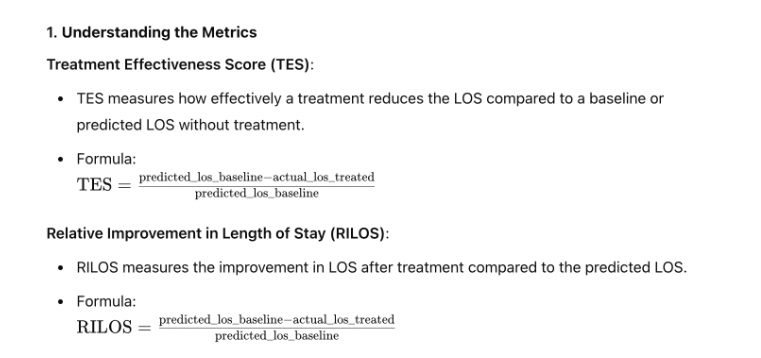

Using the above defined statistics, we can model to simulate how various treatments and dosages affect patient outcomes, specifically focusing on metrics like Length of Stay (LOS) improvements

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Simulate data
np.random.seed(42)
n_patients = 20  # Number of patients to simulate

# Sample patient data
data = {
    'age': np.random.randint(20, 80, size=n_patients),
    'gender': np.random.choice(['Male', 'Female'], size=n_patients),
    'insurance': np.random.choice(['Insurance_A', 'Insurance_B', 'Insurance_C'], size=n_patients),
    'admission_type': np.random.choice(['Emergency', 'Elective'], size=n_patients),
    'treatment_type': np.random.choice(['Treatment_A', 'Treatment_B', 'Treatment_C'], size=n_patients),
    'dosage': np.random.uniform(10, 100, size=n_patients),
    'predicted_los': np.random.uniform(3, 14, size=n_patients),
    'actual_los': np.random.uniform(3, 14, size=n_patients),
    'baseline_los': np.random.uniform(3, 14, size=n_patients),  # Added for comparison
    'patient_subject_id': np.arange(n_patients)  # Added for tracking patient IDs
}

df = pd.DataFrame(data)

# Calculate TES and RILOS
df['tes'] = (df['actual_los'] - df['predicted_los']) / df['actual_los']
df['rilos'] = (df['baseline_los'] - df['predicted_los']) / df['baseline_los']

# Encode categorical columns
le = LabelEncoder()
categorical_cols = ['gender', 'insurance', 'admission_type', 'treatment_type']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Define features and targets
features = ['age', 'gender', 'insurance', 'admission_type', 'treatment_type', 'dosage', 'predicted_los']
target_tes = 'tes'
target_rilos = 'rilos'

# Split data for TES
X_tes = df[features]
y_tes = df[target_tes]

# Split data for RILOS
X_rilos = df[features]
y_rilos = df[target_rilos]

# Train TES model
tes_model = RandomForestRegressor(n_estimators=100, random_state=42)
tes_model.fit(X_tes, y_tes)

# Train RILOS model
rilos_model = RandomForestRegressor(n_estimators=100, random_state=42)
rilos_model.fit(X_rilos, y_rilos)

# Monte Carlo Simulation Function
def monte_carlo_simulation(patient_data, treatment_options, dosage_range, n_simulations=100):
    simulation_results = []

    for _ in range(n_simulations):
        # Randomly select treatment and dosage
        treatment_type = np.random.choice(treatment_options)
        dosage = np.random.uniform(dosage_range[0], dosage_range[1])

        # Predict TES and RILOS for each patient with the new treatment scenario
        for _, patient in patient_data.iterrows():
            simulated_data = patient.copy()
            simulated_data['treatment_type'] = le.transform([treatment_type])[0]
            simulated_data['dosage'] = dosage

            simulated_df = pd.DataFrame([simulated_data])

            # Predict TES and RILOS
            predicted_tes = tes_model.predict(simulated_df[features])[0]
            predicted_rilos = rilos_model.predict(simulated_df[features])[0]

            simulation_results.append({
                'patient_id': patient['patient_subject_id'],  # Ensure column exists
                'treatment_type': treatment_type,
                'dosage': dosage,
                'predicted_tes': predicted_tes,
                'predicted_rilos': predicted_rilos
            })

    return pd.DataFrame(simulation_results)

# Example usage of the simulation
treatment_options = ['Treatment_A', 'Treatment_B', 'Treatment_C']
dosage_range = (10, 100)  # Example range for dosage
simulation_df = monte_carlo_simulation(df, treatment_options, dosage_range)

# Display simulation results
print(simulation_df.head())


   patient_id treatment_type     dosage  predicted_tes  predicted_rilos
0         0.0    Treatment_A  32.852387       0.162633         0.384605
1         1.0    Treatment_A  32.852387      -1.486469        -0.832522
2         2.0    Treatment_A  32.852387      -0.048276         0.143750
3         3.0    Treatment_A  32.852387      -0.032994         0.090491
4         4.0    Treatment_A  32.852387       0.404959         0.192775


The baseline LOS is the estimated length of stay based on historical data and standard treatments, while personalized LOS is tailored to individual patients based on specific data and treatment plans. The code compares these two to identify potential improvements in outcomes, validate predictions, and optimize treatment strategies. This helps in ensuring that the predictions are accurate, aiding in effective resource allocation and hospital planning.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Simulate data
np.random.seed(42)
n_patients = 1000

data = {
    'age': np.random.randint(20, 80, size=n_patients),
    'gender': np.random.choice(['Male', 'Female'], size=n_patients),
    'insurance': np.random.choice(['Insurance_A', 'Insurance_B', 'Insurance_C'], size=n_patients),
    'admission_type': np.random.choice(['Emergency', 'Elective'], size=n_patients),
    'treatment_type': np.random.choice(['Treatment_A', 'Treatment_B', 'Treatment_C'], size=n_patients),
    'dosage': np.random.uniform(10, 100, size=n_patients),
    'predicted_los': np.random.uniform(3, 14, size=n_patients),
    'actual_los': np.random.uniform(3, 14, size=n_patients),
    'baseline_los': np.random.uniform(3, 14, size=n_patients)
}

df = pd.DataFrame(data)

# Define categorical columns
categorical_cols = ['gender', 'insurance', 'admission_type', 'treatment_type']

# Create Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Define features and targets for baseline LOS model
features = categorical_cols + ['age', 'dosage', 'predicted_los']
target_baseline = 'baseline_los'
target_predicted = 'predicted_los'

# Split data for baseline LOS
X_baseline = df[features]
y_baseline = df[target_baseline]
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, test_size=0.3, random_state=42)

# Train Baseline LOS model
pipeline_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
pipeline_baseline.fit(X_train_baseline, y_train_baseline)

# Evaluate Baseline LOS model
baseline_predictions = pipeline_baseline.predict(X_test_baseline)
print(f'Baseline LOS Model Mean Squared Error: {mean_squared_error(y_test_baseline, baseline_predictions)}')

# Split data for predicted LOS
X_predicted = df[features]
y_predicted = df[target_predicted]
X_train_predicted, X_test_predicted, y_train_predicted, y_test_predicted = train_test_split(X_predicted, y_predicted, test_size=0.3, random_state=42)

# Train Predicted LOS model
pipeline_predicted = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
pipeline_predicted.fit(X_train_predicted, y_train_predicted)

# Evaluate Predicted LOS model
predicted_predictions = pipeline_predicted.predict(X_test_predicted)
print(f'Predicted LOS Model Mean Squared Error: {mean_squared_error(y_test_predicted, predicted_predictions)}')

# Function to predict LOS for new data
def predict_los_for_new_data(new_data, pipeline):
    new_data_encoded = new_data.copy()
    predictions = pipeline.predict(new_data_encoded)
    return predictions

# Example new patient data
new_patient_data = pd.DataFrame({
    'age': [50],
    'gender': ['Male'],
    'insurance': ['Insurance_B'],
    'admission_type': ['Elective'],
    'treatment_type': ['Treatment_A'],
    'dosage': [60],
    'predicted_los': [7]
})

# Predict baseline LOS for new patient
baseline_los_prediction = predict_los_for_new_data(new_patient_data, pipeline_baseline)
print(f'Predicted Baseline LOS for new patient: {baseline_los_prediction[0]:.2f} days')

# Predict LOS based on treatment for new patient
predicted_los_prediction = predict_los_for_new_data(new_patient_data, pipeline_predicted)
print(f'Predicted LOS for new patient with treatment: {predicted_los_prediction[0]:.2f} days')


Baseline LOS Model Mean Squared Error: 10.794161574157696
Predicted LOS Model Mean Squared Error: 0.00020683793823043011
Predicted Baseline LOS for new patient: 8.49 days
Predicted LOS for new patient with treatment: 6.99 days


In [ ]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.71.26.195


In [ ]:
import streamlit as st
streamlit_code = ""
# Streamlit app
st.title('LOS Prediction for Patients')

# User input form
with st.form(key='patient_form'):
    age = st.number_input('Age', min_value=0, max_value=120, value=50)
    gender = st.selectbox('Gender', options=['Male', 'Female'])
    insurance = st.selectbox('Insurance', options=['Insurance_A', 'Insurance_B', 'Insurance_C'])
    admission_type = st.selectbox('Admission Type', options=['Emergency', 'Elective'])
    treatment_type = st.selectbox('Treatment Type', options=['Treatment_A', 'Treatment_B', 'Treatment_C'])
    dosage = st.number_input('Dosage', min_value=0.0, max_value=100.0, value=60.0)
    predicted_los = st.number_input('Predicted LOS', min_value=0.0, max_value=20.0, value=7.0)

    submit_button = st.form_submit_button(label='Predict')

    if submit_button:
        # Create DataFrame for prediction
        new_patient_data = pd.DataFrame({
            'age': [age],
            'gender': [gender],
            'insurance': [insurance],
            'admission_type': [admission_type],
            'treatment_type': [treatment_type],
            'dosage': [dosage],
            'predicted_los': [predicted_los]
        })

        # Predict baseline LOS for new patient
        baseline_los_prediction = pipeline_baseline.predict(new_patient_data)
        st.write(f'Predicted Baseline LOS for new patient: {baseline_los_prediction[0]:.2f} days')

        # Predict LOS based on treatment for new patient
        predicted_los_prediction = pipeline_predicted.predict(new_patient_data)
        st.write(f'Predicted LOS for new patient with treatment: {predicted_los_prediction[0]:.2f} days')

with open('streamlit_app.py', 'w') as f:
    f.write(streamlit_code)

In [ ]:
!streamlit run streamlit_app.py & npx localtunnel --port 8501





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.71.26.195:8501

Need to install the following packages:
  localtunnel@2.0.2
Ok to proceed? (y)   Stopping...
^C
